In [2]:
import pennylane as qml
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import pandas as pd
import argparse
import os
import math
import datetime
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.utils.data as data

import torch.nn as nn
import torch.nn.functional as F
import torch

# dev = qml.device('cirq.simulator', wires=2)
dev = qml.device('default.qubit', wires=2)

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=16, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.001, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--sample_interval", type=int, default=100, help="interval betwen image samples")
parser.add_argument("--k", type=int, default=2, help="multiple discriminator iterations")
config = parser.parse_known_args()[0]
print(config)

Namespace(b1=0.5, b2=0.999, batch_size=16, k=2, latent_dim=100, lr=0.001, n_cpu=8, n_epochs=50, sample_interval=100)


In [4]:
cuda = True if torch.cuda.is_available() else False

@qml.qnode(dev, interface='torch')
def gen_circuit(w):
    # Sample noise as generator input
    z = random.uniform(-1, 1)

    qml.RY(np.arcsin(z), wires=0)
    qml.RY(np.arcsin(z), wires=1)
    qml.RZ(np.arccos(z), wires=0)
    qml.RZ(np.arccos(z), wires=1)
    qml.RY(w[0], wires=0)
    qml.RY(w[1], wires=1)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    qml.CNOT(wires=[0, 1])
    qml.RZ(w[2], wires=1)
    qml.CNOT(wires=[0, 1])

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    return qml.expval(qml.PauliZ(0))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, sample):
        sample_flat = sample.view(sample.size(0), -1)
        validity = self.model(sample_flat)

        return validity

In [5]:
# Loss function
adversarial_loss = torch.nn.BCELoss(size_average=False)
discriminator = Discriminator()

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

if cuda:
    discriminator.cuda()
    adversarial_loss.cuda()
    
device = torch.device("cuda" if cuda else "cpu")
device

/home/junde/anaconda3/envs/kongsr-rdkit/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


device(type='cpu')

In [6]:
class BimodalDataset(data.Dataset):
    """Bimodal distribution dataset."""
    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.df = pd.read_csv(csv_file, header=None)
    def __len__(self):
        return len(self.df.to_numpy()[0])
    def __getitem__(self, idx):
        item = self.df.to_numpy()[0][idx]
        return item 
 
filename = 'data_bimodal.csv'
dataset = BimodalDataset(filename)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, shuffle=False)

In [7]:
list(np.random.rand(3))

[0.49515361889649034, 0.17200362900831057, 0.1768981042319424]

In [11]:
# Adversarial ground truths
valid = Variable(Tensor(config.batch_size).fill_(1.0), requires_grad=False)
fake = Variable(Tensor(config.batch_size).fill_(0.0), requires_grad=False)
init_weights = list(np.random.rand(3))
print('Initial generator weights:', init_weights)
print()
gen_weights = torch.tensor(list(np.random.rand(3)), requires_grad=True)
# optimizer_G = torch.optim.Adam([gen_weights], lr = config.lr)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=config.lr)
optimizer_G = torch.optim.SGD([gen_weights], lr=config.lr, momentum=0.9)
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=config.lr, momentum=0.9)
best_g_loss = np.inf


# Start training.
print('Start training...')

for epoch in range(config.n_epochs):    
    # learning rate decay
    if (epoch+1) % 10 == 0:
        config.lr = config.lr * .6
        print()
        print('Training with learning rate:', config.lr)
        
    for i, samples in enumerate(dataloader):
        # Configure input
        real_samples = Variable(samples.type(Tensor))
        
        # -----------------
        #  Train Generator
        # -----------------
#         if (i%5 == 0):
        optimizer_G.zero_grad()

        # Generate a batch of samples
        sample_list = [gen_circuit(gen_weights) for i in range(config.batch_size)]
        gen_samples = torch.stack(tuple(sample_list)).to(device).float()
#         loss = adversarial_loss(discriminator(torch.unsqueeze(gen_samples, 1)), valid)
        loss = adversarial_loss(discriminator(gen_samples), valid)
        g_loss = loss.mean()
        
        # keep track of best G loss and generator parameters
        if g_loss < best_g_loss:
            best_g_loss = g_loss
            best_g_weights = gen_weights            

        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        for j in range(config.k):
            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_samples), valid)
            fake_loss = adversarial_loss(discriminator(gen_samples.detach().float()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward(retain_graph=True)
            optimizer_D.step()
        
        if i % config.sample_interval == 0:
            print(
                "%s\t[Epoch %d/%d  Batch %d/%d]\t[D loss: %f]\t[G loss: %f]"
                % (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), epoch+1, config.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
            print(gen_weights.detach())

Initial generator weights: [0.016268182625356675, 0.06565351014879672, 0.6636422604047488]

Start training...
2020-09-25 17:24:09	[Epoch 1/50  Batch 0/625]	[D loss: 6.944081]	[G loss: 80.087517]
tensor([0.5656, 0.2092, 0.0303], dtype=torch.float64)
2020-09-25 17:24:25	[Epoch 1/50  Batch 100/625]	[D loss: 7.755075]	[G loss: 19.084652]
tensor([ 0.2601,  0.2956, -1.2612], dtype=torch.float64)


KeyboardInterrupt: 

In [ ]:
gen_weights.detach().numpy()

In [17]:
samples = []
num_samples = 1000
w = [1.8302, 2.1733, 4.2969]
for i in range(num_samples):
    samples.append(gen_circuit(w))

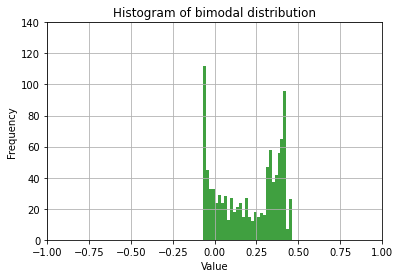

In [18]:
# the histogram of the data
plt.hist(samples, 30, facecolor='g', alpha=0.75)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of bimodal distribution')
plt.xlim(-1, 1)
plt.ylim(0, 140)
plt.grid(True)
plt.show()